# Mar-?-2021 (overlapping comm)

**Motivation**: Overlapping communities.<br>

In [1]:
# HIDE CODE


# generic imports
import re
import os
import sys
import random
import itertools
import collections
import numpy as np
import pandas as pd
import networkx as nx
import nibabel as nib
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from os.path import join as pjoin
from operator import itemgetter
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import patches
from matplotlib import cm
import seaborn as sns
sns.set_style('white')

# GitHub
git_path = pjoin(os.environ['HOME'], 'Dropbox/git/Ca-fMRI/')
sys.path.insert(0, git_path)
from simulation.simulation import *
from tqdm.notebook import tqdm

# nx imports
import networkx as nx
import networkx.algorithms.community as nx_comm
from networkx.generators.random_graphs import erdos_renyi_graph
from networkx.classes.function import density

# network measures
from networkx.algorithms.cluster import transitivity, average_clustering
from networkx.algorithms.assortativity import degree_pearson_correlation_coefficient
from networkx.algorithms.efficiency_measures import global_efficiency, local_efficiency
from networkx.algorithms.approximation.clique import large_clique_size
from networkx.algorithms.shortest_paths.generic import average_shortest_path_length
from networkx.algorithms.smallworld import sigma, omega

# Louvain
import community as community_louvain


# fix random stete
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

## Simulation

Now with overlapping block structure.

### Overlapping communities

Still using the hierarchichal-modular (HM) model.

In [2]:
# HIDE CODE


non_overlap = 20
overlap = 10
num_blocks = 10

# a_c = get_adjacency(block_size=block_size, num_blocks=num_blocks, mode='RAND')
a_m = get_adjacency(
    non_overlap=non_overlap,
    overlap=overlap,
    num_blocks=num_blocks,
    mode='M',
    random_state=RANDOM_STATE,
)
a_hm = get_adjacency(
    non_overlap=non_overlap,
    overlap=overlap,
    num_blocks=num_blocks,
    mode='HM',
    random_state=RANDOM_STATE,
)

g_m = nx.from_numpy_matrix(a_m)
g_hm = nx.from_numpy_matrix(a_hm)

# get configuration model
sequence = sorted([d for n, d in g_hm.degree()], reverse=True)
g_c = nx.configuration_model(sequence)
g_c = nx.Graph(g_c)
g_c.remove_edges_from(nx.selfloop_edges(g_c))
a_c = nx.adjacency_matrix(g_c).toarray()

# put in dicts
graphs = {'C': g_c, 'M': g_m, 'HM': g_hm}
adjacencies = {'C': a_c, 'M': a_m, 'HM': a_hm}
laplacians = {k: nx.laplacian_matrix(g).toarray() for k, g in graphs.items()}
norm_laplacians = {k: nx.normalized_laplacian_matrix(g).toarray() for k, g in graphs.items()}
eigs = {k: np.linalg.eigh(a) for k, a in adjacencies.items()}
poses = {k: nx.spring_layout(g, iterations=300 if k == 'C' else 500) for k, g in graphs.items()}
cmaps = {'C': 'Purples', 'M': 'Reds', 'HM': 'Blues'}
palette = sns.color_palette('tab10', n_colors=10, as_cmap=False)
colors = np.array(palette)[[4, 3, 0]]
colors = {k: colors[i] for i, k in enumerate(cmaps.keys())}

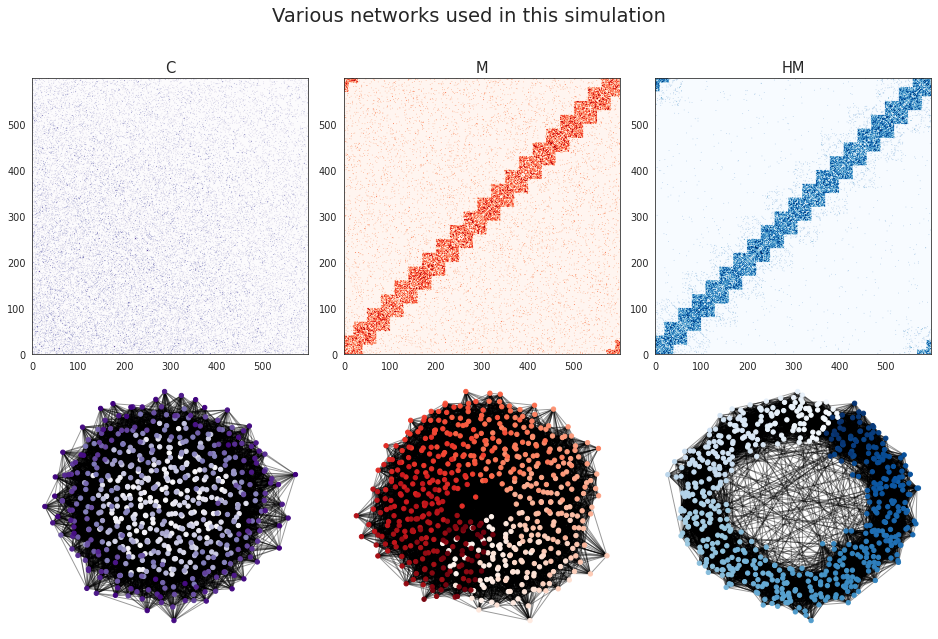

In [3]:
# HIDE CODE


figsize = (13.5, 9)
dpi = 70

sns.set_style('white')
fig = plt.figure(figsize=figsize, dpi=dpi)
gs = GridSpec(nrows=2, ncols=3, height_ratios=[1.3, 1], hspace=0)

for idx, (k, g) in enumerate(graphs.items()):
    ax0 = fig.add_subplot(gs[0, idx])
    ax1 = fig.add_subplot(gs[1, idx])
    
    im = ax0.imshow(adjacencies[k], cmap=cmaps[k], interpolation='antialiased')
    ax0.invert_yaxis()
    ax0.set_title(k, fontsize=15)

    nx.draw_networkx_nodes(g, poses[k], node_color=range(g.order()), node_size=20, cmap=cmaps[k], ax=ax1)
    nx.draw_networkx_edges(g, poses[k], alpha=0.4, ax=ax1)
    ax1.axis('off')

fig.suptitle('Various networks used in this simulation', fontsize=20, y=1.01)
fig.tight_layout(h_pad=0)
plt.show()

In [4]:
adjacencies['HM'].shape

(600, 600)

In [5]:
np.mean(adjacencies['HM'] - adjacencies['HM'].T)

0.0

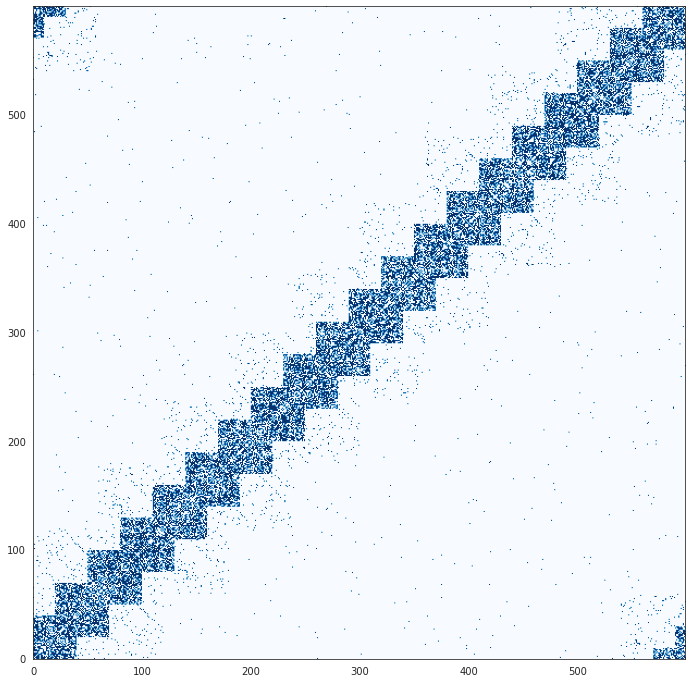

In [6]:
plt.figure(figsize=(15, 12))
plt.imshow(adjacencies['HM'], cmap=cmaps['HM'])
plt.gca().invert_yaxis()

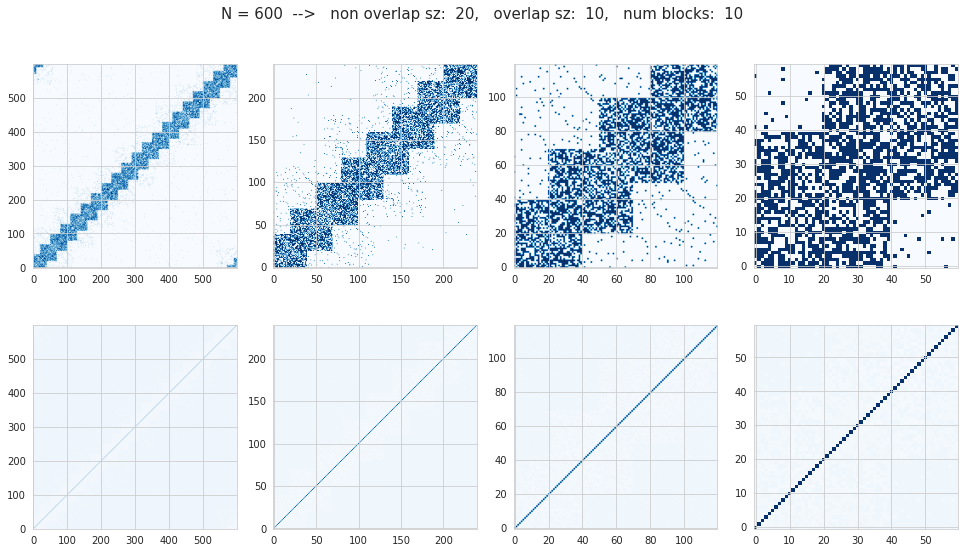

In [8]:
sizes = [non_overlap, 4, 2, 1]
sizes = [(non_overlap + overlap) * 2 * s for s in sizes]

sns.set_style('whitegrid')
fig, axes = plt.subplots(2, len(sizes), figsize=(13.5, 8))

for j, size in enumerate(sizes):
    axes[0, j].imshow(adjacencies['HM'][:size, :size], cmap=cmaps['HM'], interpolation="antialiased")
    axes[1, j].imshow(norm_laplacians['HM'][:size, :size], cmap=cmaps['HM'], interpolation="antialiased")
    axes[0, j].invert_yaxis()
    axes[1, j].invert_yaxis()

msg = 'N = {:d}  -->   non overlap sz:  {:d},   overlap sz:  {:d},   num blocks:  {:d}'
msg = msg.format(len(adjacencies['HM']), non_overlap, overlap, num_blocks)
fig.suptitle(msg, fontsize=15)
fig.tight_layout()
plt.show()

### cdlib

In [21]:
from cdlib import algorithms

In [17]:
# HIDE CODE


# run algorithm
communities_louvain = {}
max_k = 100
for k, g in tqdm(graphs.items(), leave=False):
    tmp = {}
    for resolution in tqdm(np.logspace(-2, 1, max_k+1), leave=False):
        coms = algorithms.louvain(g, resolution=resolution) 
        tmp[resolution] = coms.communities
    communities_louvain[k] = tmp


# process results
modularities_louvain = {}
num_communities_louvain = {}

for k, g in graphs.items():
    modul = {}
    num_comm = {}
    for resolution, coms_list in communities_louvain[k].items():
        modul[resolution] = nx_comm.modularity(g, communities=coms_list)
        num_comm[resolution] = len(coms_list)
    
    modularities_louvain[k] = modul
    num_communities_louvain[k] = num_comm

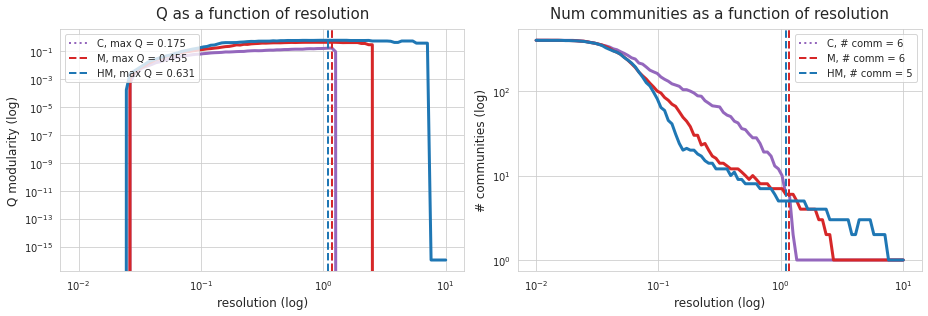

In [19]:
# HIDE CODE


sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(13, 4.5), sharex='all')

for k, color in colors.items():
    x0, y0 = tuple(zip(*modularities_louvain[k].items()))
    axes[0].loglog(x0, y0, lw=3, color=color)
    ls = '--' if k in ['M', 'HM'] else ':'
    max_mod_idx = np.argmax(y0)
    max_mod = y0[max_mod_idx]
    res_at_max_mod = x0[max_mod_idx]
    lbl = '{}, max Q = {:.3f}'.format(k, max_mod)
    axes[0].axvline(res_at_max_mod, color=color, lw=2, ls=ls, label=lbl)
    
    x1, y1 = tuple(zip(*num_communities_louvain[k].items()))
    axes[1].loglog(x1, y1, lw=3, color=color)
    lbl = '{}, # comm = {:d}'.format(k, y1[max_mod_idx])
    axes[1].axvline(res_at_max_mod, color=color, lw=2, ls=ls, label=lbl)

axes[0].set_title('Q as a function of resolution', fontsize=15, y=1.02)
axes[0].set_xlabel('resolution (log)', fontsize=12)
axes[0].set_ylabel('Q modularity (log)', fontsize=12)
axes[0].legend(loc='upper left')

axes[1].set_title('Num communities as a function of resolution', fontsize=15, y=1.02)
axes[1].set_xlabel('resolution (log)', fontsize=12)
axes[1].set_ylabel('# communities (log)', fontsize=12)
axes[1].legend(loc='upper right')

fig.tight_layout()
plt.show()

### Lieden

In [22]:
communities_leiden = {}
modularities_leiden = {}

for k, g in graphs.items():
    coms = algorithms.leiden(g)
    community_list = [sorted(item) for item in coms.communities]
    community_list = sorted(community_list, key=lambda x: sorted(x)[0])
    communities_leiden[k] = community_list
    modularities_leiden[k] = nx_comm.modularity(g, community_list)

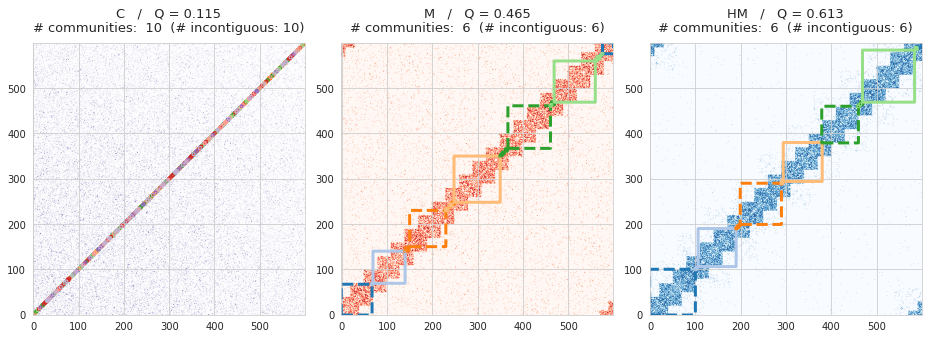

In [23]:
# HIDE CODE


sns.set_style('whitegrid')
fig, axes = plt.subplots(1, len(graphs), figsize=(13, 6))

for j, name in enumerate(graphs.keys()):
        axes[j].imshow(adjacencies[name], cmap=cmaps[name], alpha=0.8)
        axes[j].invert_yaxis()

        community_list = communities_leiden[name]
        palette = sns.color_palette('tab20', n_colors=len(community_list))
        num_incontiguous = 0
        for ll, (comm_list, color) in enumerate(zip(community_list, palette)):
            contiguous_list = []
            for k, g in itertools.groupby(enumerate(comm_list), lambda ix: ix[0]-ix[1]):
                contiguous_list.append(list(map(itemgetter(1), g)))

            if len(contiguous_list) > 1:
                num_incontiguous += 1

            for item in contiguous_list:
                rect = patches.FancyBboxPatch(
                    (item[0],) * 2,
                    item[-1] - item[0],
                    item[-1] - item[0],
                    linewidth=3,
                    edgecolor=color,
                    facecolor='none',
                    boxstyle="round,pad=1",
                    ls='--' if ll%2==0 else '-',
                )
                axes[j].add_patch(rect)

        msg = "{:s}   /   Q = {:.3f}\n# communities:  {:d}  (# incontiguous: {:d})"
        msg = msg.format(name, modularities_leiden[name], len(community_list), num_incontiguous)
        axes[j].set_title(msg, fontsize=13, y=1.02)

fig.tight_layout()
plt.show()

### nmnf

In [24]:
coms = algorithms.nmnf(graphs['HM'], clusters=29)
community_list = [sorted(item) for item in coms.communities]
community_list = sorted(community_list, key=lambda x: sorted(x)[0])
len(community_list)

29

FitnessResult(min=None, max=None, score=0.423269878056302, std=None)

In [25]:
coms.newman_girvan_modularity()

FitnessResult(min=None, max=None, score=0.27143660226485505, std=None)

In [26]:
coms.z_modularity()

FitnessResult(min=None, max=None, score=1.4638870207459171, std=None)

In [27]:
coms.modularity_density()

FitnessResult(min=None, max=None, score=-27.173155736776472, std=None)

In [28]:
coms.conductance()

FitnessResult(min=0.5873715124816447, max=0.8287937743190662, score=0.7008230794441758, std=0.04822812842369752)

In [29]:
coms.surprise()

FitnessResult(min=None, max=None, score=4652.87266418564, std=None)

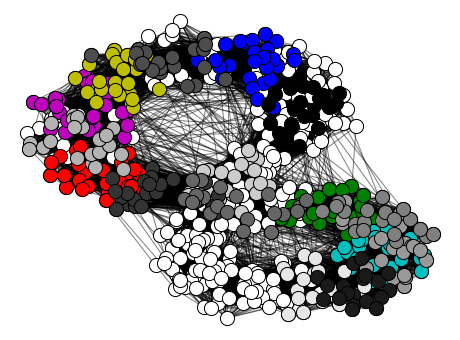

In [30]:
from cdlib import viz

viz.plot_network_clusters(
    graphs['HM'], coms, position=None, figsize=(8, 6),
    node_size=200, plot_overlaps=False, plot_labels=False, cmap=None, top_k=None, min_size=None)

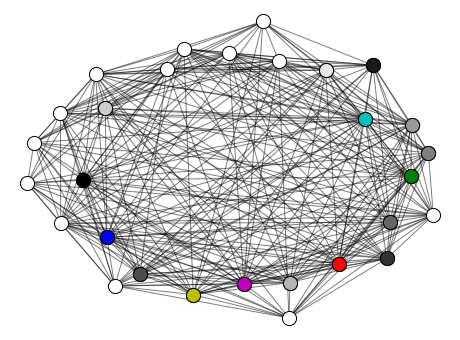

In [31]:
viz.plot_community_graph(
    graphs['HM'], coms, figsize=(8, 6), node_size=200,
    plot_overlaps=False, plot_labels=False, cmap=None, top_k=None, min_size=None)

### DeepWalk embedding

In [12]:
from karateclub import DeepWalk

g = nx.newman_watts_strogatz_graph(graphs['HM'].order(), 2 * (non_overlap + overlap), 0.05)

model = DeepWalk(dimensions=128, learning_rate=0.01)
model.fit(g)
embedding = model.get_embedding()

In [13]:
a_nws = nx.adjacency_matrix(g).toarray()

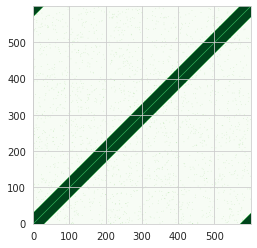

In [14]:
plt.imshow(a_nws, cmap='Greens')
plt.gca().invert_yaxis()

In [15]:
embedding.shape

(600, 128)

In [16]:
import numpy as np
from sklearn.manifold import TSNE
x = TSNE(n_components=2, perplexity=50).fit_transform(embedding)
x.shape

(600, 2)

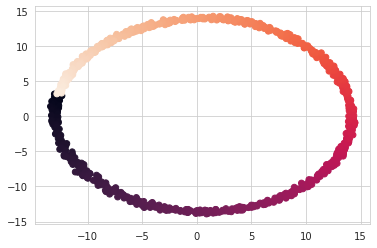

In [17]:
plt.scatter(x[:, 0], x[:, 1], c=range(len(x)))

In [18]:
model = DeepWalk(dimensions=128, learning_rate=0.01)
model.fit(graphs['HM'])
embedding = model.get_embedding()
embedding.shape

(600, 128)

In [19]:
import numpy as np
from sklearn.manifold import TSNE
x = TSNE(n_components=2, perplexity=50).fit_transform(embedding)
x.shape

(600, 2)

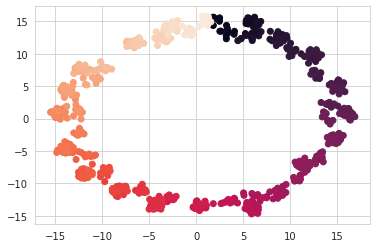

In [20]:
plt.scatter(x[:, 0], x[:, 1], c=range(len(x)))

## Network measures

In this section I will study in what ways these networks are different or similar using well known network measures.

### Degree distribution

I chose the parameters in generating the simulation in a way that all these networks have roughly the same digree distribution.

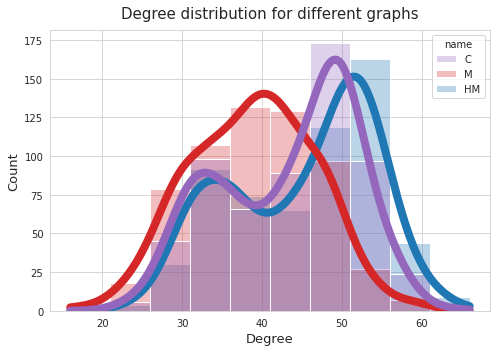

In [32]:
# HIDE CODE


deg_df = pd.DataFrame()

for k, g in graphs.items():
    nodes, degrees = list(zip(*g.degree()))
    data_dict = {
        'name': [k] * len(nodes),
        'node': nodes,
        'deg': degrees,
    }
    deg_df = pd.concat([deg_df, pd.DataFrame.from_dict(data_dict)])
    
sns.set_style('whitegrid')
plt.figure(figsize=(7, 5))
sns.histplot(
    data=deg_df, x='deg', hue='name', palette=colors, kde=True, bins=10,
    element='bars', fill=True, alpha=0.3, line_kws={'lw': 8})
plt.title('Degree distribution for different graphs', fontsize=15, y=1.02)
plt.xlabel('Degree', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.tight_layout()
plt.show()

In [53]:
# HIDE CODE


measures_df = pd.DataFrame()

for k, g in graphs.items():
    nodes, degrees = list(zip(*g.degree()))
    
    data_dict = {
        'name': [k] * 8,
        'lbl': [
            'transitivity',
            'avg_clustering',
            'large_clique_size',
            'degree_corr_coef',
            'avg_shortest_path_len',
            'local_efficiency',
            'global_efficiency',
            'sigma',
            # 'omega',
        ],
        'val': [
            transitivity(g),
            average_clustering(g),
            large_clique_size(g),
            degree_pearson_correlation_coefficient(g),
            average_shortest_path_length(g),
            local_efficiency(g),
            global_efficiency(g),
            sigma(g, niter=1, nrand=1, seed=42),
            # omega(g, niter=1, nrand=1, seed=42),
        ],
    }
    measures_df = pd.concat([measures_df, pd.DataFrame.from_dict(data_dict)])

### Other measures

Here I will discuss 8 commonly used network measures and then report their values on different networks in the simulation.

#### i) Clustering related measures
- **transitivity**:
- **avg_clustering**: 
- **large_clique_size**:
- **assortativity**:

#### ii) Path length related measures
- **avg_shortest_path_len**:
- **local_efficiency**:
- **global_efficiency**:

#### iii) Small-world-ness
- **sigma**: introduced in... 


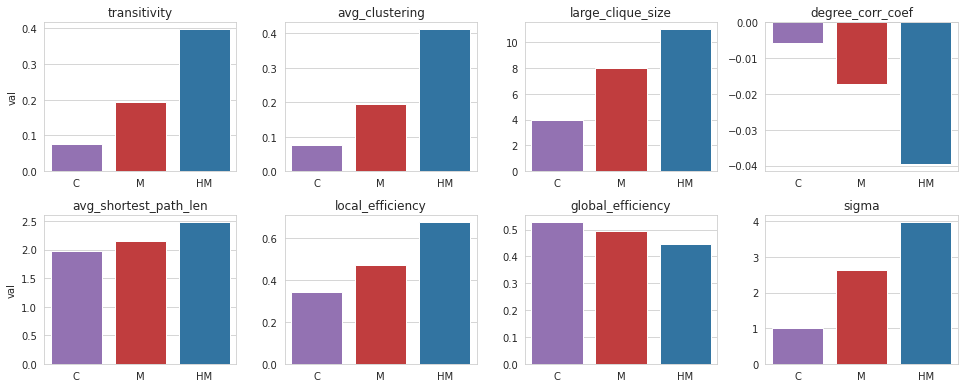

In [55]:
# HIDE CODE


sns.set_style('whitegrid')
nrows, ncols = 2, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 5.5))

for idx, lbl in enumerate(measures_df.lbl.unique()):
    i, j = idx//ncols, idx%ncols
    sns.barplot(
        data=measures_df.loc[measures_df.lbl == lbl],
        y='val', x='name', palette=colors, ax=axes[i, j],
    )
    axes[i, j].set_title(lbl, fontsize=12)
    axes[i, j].set_xlabel('')
    if j > 0:
        axes[i, j].set_ylabel('')
    
fig.tight_layout()
plt.show()

interpretation of results:

## Centrality measures

Now we bring our focus from the network as a whole to individual nodes.  Some of these nodes are more *central* than others.  What do I mean by central?  Here is measures I will report on:

- **Degree centrality**:
- **Closeness centrality**:
- **Harmonic centrality**:
- **Betweenness centrality**:
- **Information centrality**:
- **Eigenvector centrality**:
- **Katz centrality**:

Now let's visualize the network based on these centrality measures.

In [33]:
# HIDE CODE


centralities = {}

for k, g in graphs.items():
    centralities[k] = {
        'degree': nx.degree_centrality(g),
        'closeness': nx.closeness_centrality(g),
        'harmonic': nx.harmonic_centrality(g),
        'betweenness': nx.betweenness_centrality(g),
        'information': nx.information_centrality(g),
        'eigenvector': nx.eigenvector_centrality(g),
        'katz': nx.katz_centrality_numpy(g),
    }

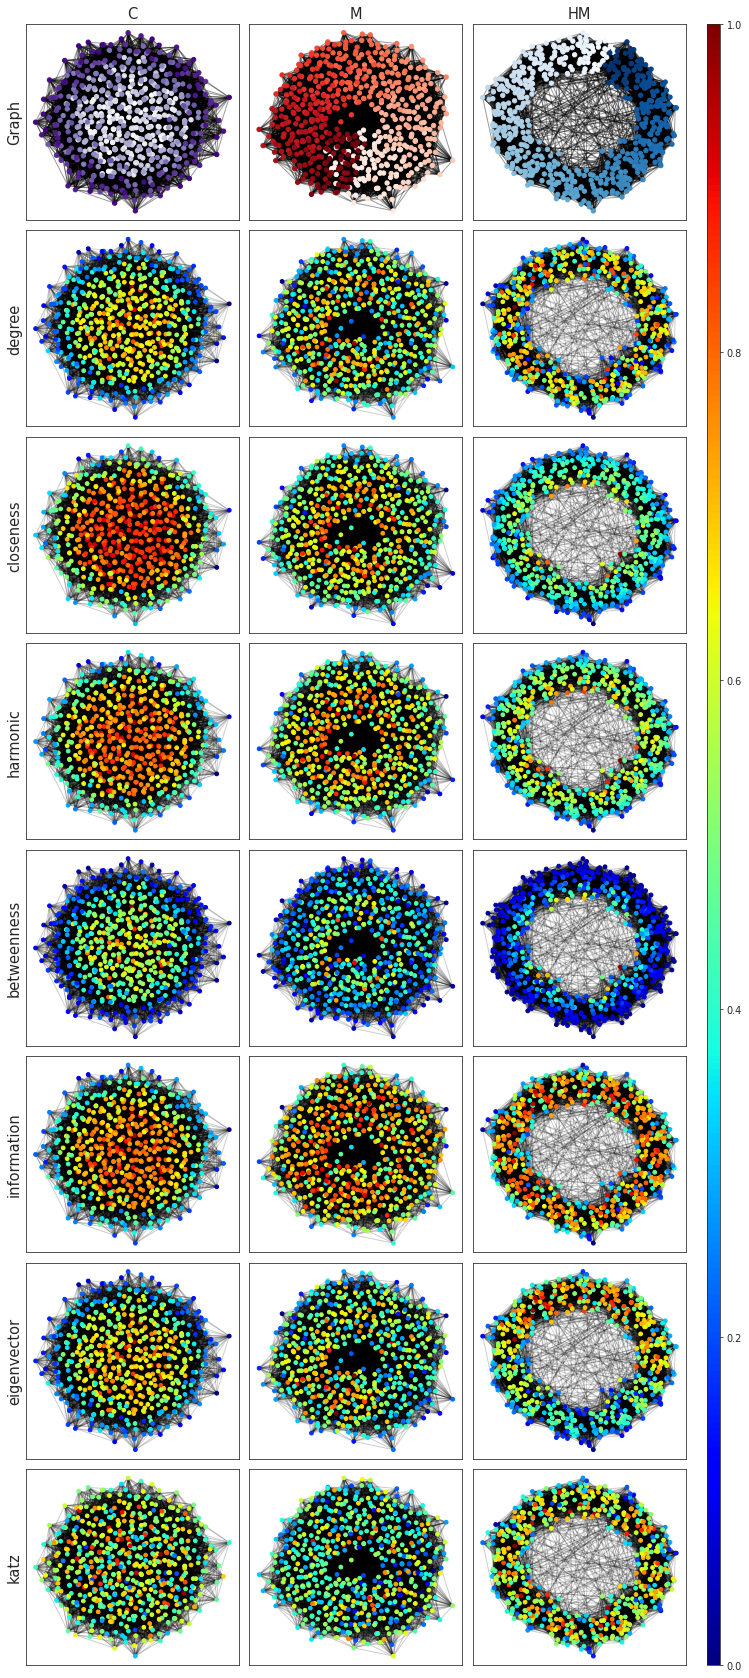

In [34]:
# HIDE CODE


figsize = (10, 24)
dpi = 70

sns.set_style('white')
nrows, ncols= len(centralities['C']) + 1, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, dpi=dpi)

for i, (k, g) in enumerate(graphs.items()):

    nx.draw_networkx_nodes(g, poses[k], node_color=range(g.order()), node_size=20, cmap=cmaps[k], ax=axes[0, i])
    nx.draw_networkx_edges(g, poses[k], alpha=0.4, ax=axes[0, i])
    axes[0, i].set_title(k, fontsize=15)
    if i == 0:
        axes[0, i].set_ylabel('Graph', fontsize=15)
    # axes[0, i].axis('off')
    
    for j, (lbl, vals) in enumerate(centralities[k].items()):
        a = min(vals.values())
        b = max(vals.values())
        normalized_vals = [(x-a) / (b-a) for x in vals.values()]
        
        nx.draw_networkx_nodes(g, poses[k], node_color=normalized_vals,
                               node_size=15, cmap='jet', ax=axes[j+1, i])
        nx.draw_networkx_edges(g, poses[k], alpha=0.2, ax=axes[j+1, i])
        if i == 0:
            axes[j+1, i].set_ylabel(lbl, fontsize=15)
        # axes[j+1, i].axis('off')

fig.tight_layout()

pos0 = axes[0, -1].get_position()
pos1 = axes[-1, -1].get_position()
rect = [
    pos1.x0 + 1.1 * pos1.width, # left
    pos1.y0, # bottom
    pos1.width / 17, # width
    pos0.y0 - pos1.y0 + pos1.height, # height
]
cax = fig.add_axes(rect)
fig.colorbar(cm.ScalarMappable(cmap='jet'), cax=cax, orientation="vertical")
plt.show()

interpret the graph

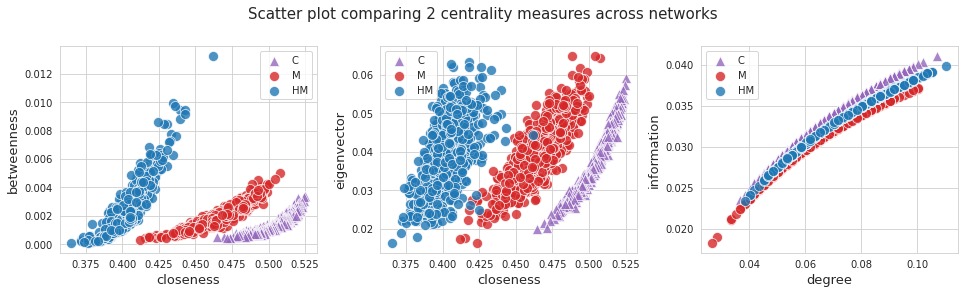

In [35]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(13.5, 4))

pairs = [('closeness', 'betweenness'), ('closeness', 'eigenvector'), ('degree', 'information')]
for idx, (x, y) in enumerate(pairs):
    for k, color in colors.items():
        marker = '^' if k in ['C', 'ER'] else 'o'
        sns.scatterplot(
            x=list(centralities[k][x].values()),
            y=list(centralities[k][y].values()),
            color=color, s=100, label=k, marker=marker, alpha=0.8, ax=axes[idx],
        )
    axes[idx].set_xlabel(x, fontsize=13)
    axes[idx].set_ylabel(y, fontsize=13)

fig.suptitle('Scatter plot comparing 2 centrality measures across networks', fontsize=15, y=1.01)
fig.tight_layout()
plt.show()

interpret the graph

## Community structure

Time for fun stuff.  In this section I will study behavior of different community detection algorithms on simulated networks.  First, let's start with a classic, but not so great algorithm.  In this section we will use another network measure known as modularity:

- **Modularity**: $Q = \frac{1}{N}\sum_i$

### Louvain algorithm

Wants to directly maximize Q, modularity

In [36]:
# HIDE CODE


# run algorithm
communities_louvain = {}
max_k = 1000
for k, g in tqdm(graphs.items(), leave=False):
    tmp = {}
    for resolution in tqdm(np.logspace(-2, 1, max_k+1), leave=False):
        partition = community_louvain.best_partition(g, resolution=resolution, random_state=RANDOM_STATE)
        
        comm = collections.defaultdict(list)
        for node, v in sorted(partition.items()):
            comm[v].append(node)  
        tmp[resolution] = dict(comm)
        
    communities_louvain[k] = tmp


# process results
modularities_louvain = {}
num_communities_louvain = {}

for k, g in graphs.items():
    modul = {}
    num_comm = {}
    for resolution, partition in communities_louvain[k].items():
        community_list = list(partition.values())
        modul[resolution] = nx_comm.modularity(g, communities=community_list)
        num_comm[resolution] = len(community_list)
    
    modularities_louvain[k] = modul
    num_communities_louvain[k] = num_comm

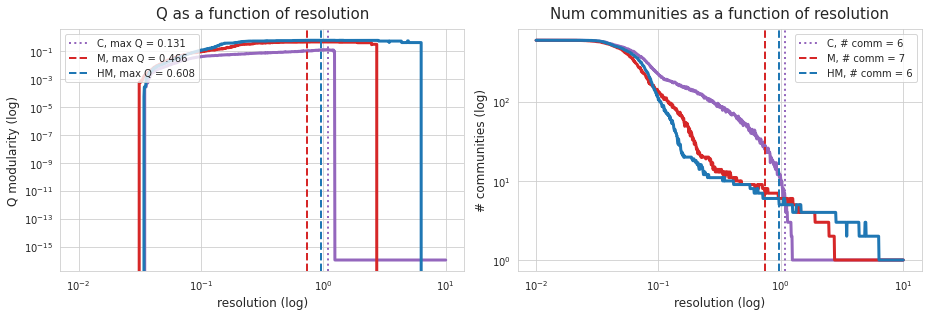

In [37]:
# HIDE CODE


fig, axes = plt.subplots(1, 2, figsize=(13, 4.5), sharex='all')

for k, color in colors.items():
    x0, y0 = tuple(zip(*modularities_louvain[k].items()))
    axes[0].loglog(x0, y0, lw=3, color=color)
    ls = '--' if k in ['M', 'HM'] else ':'
    max_mod_idx = np.argmax(y0)
    max_mod = y0[max_mod_idx]
    res_at_max_mod = x0[max_mod_idx]
    lbl = '{}, max Q = {:.3f}'.format(k, max_mod)
    axes[0].axvline(res_at_max_mod, color=color, lw=2, ls=ls, label=lbl)
    
    x1, y1 = tuple(zip(*num_communities_louvain[k].items()))
    axes[1].loglog(x1, y1, lw=3, color=color)
    lbl = '{}, # comm = {:d}'.format(k, y1[max_mod_idx])
    axes[1].axvline(res_at_max_mod, color=color, lw=2, ls=ls, label=lbl)

axes[0].set_title('Q as a function of resolution', fontsize=15, y=1.02)
axes[0].set_xlabel('resolution (log)', fontsize=12)
axes[0].set_ylabel('Q modularity (log)', fontsize=12)
axes[0].legend(loc='upper left')

axes[1].set_title('Num communities as a function of resolution', fontsize=15, y=1.02)
axes[1].set_xlabel('resolution (log)', fontsize=12)
axes[1].set_ylabel('# communities (log)', fontsize=12)
axes[1].legend(loc='upper right')

fig.tight_layout()
plt.show()

interpret this graph

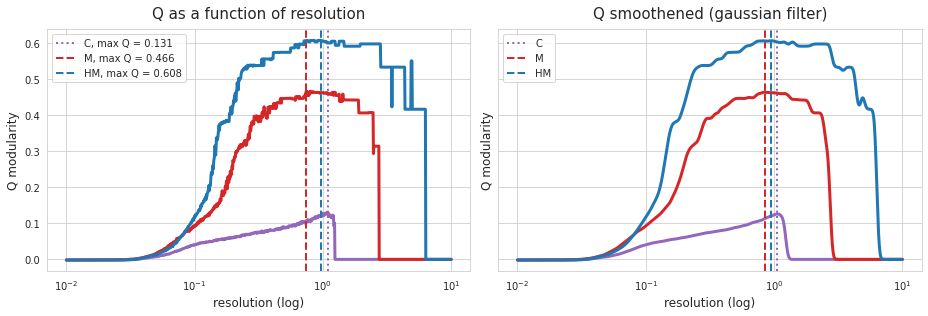

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4.5), sharex='all', sharey='all')

for j in range(2):
    for k, color in colors.items():
        x0, y0 = tuple(zip(*modularities_louvain[k].items()))
        if j == 1:
            y0 = gaussian_filter(y0, sigma=5)
        axes[j].plot(x0, y0, lw=3, color=color)
        ls = '--' if k in ['M', 'HM'] else ':'
        max_mod_idx = np.argmax(y0)
        max_mod = y0[max_mod_idx]
        res_at_max_mod = x0[max_mod_idx]
        lbl = '{}, max Q = {:.3f}'.format(k, max_mod) if j == 0 else '{}'.format(k)
        axes[j].axvline(res_at_max_mod, color=color, lw=2, ls=ls, label=lbl)
        axes[j].set_xscale('log')
        axes[j].legend(loc='upper left')
        axes[j].set_xlabel('resolution (log)', fontsize=12)
        axes[j].set_ylabel('Q modularity', fontsize=12)

axes[0].set_title('Q as a function of resolution', fontsize=15, y=1.02)
axes[1].set_title('Q smoothened (gaussian filter)', fontsize=15, y=1.02)

fig.tight_layout()
plt.show()

interpret this graph, and talk about Q could be misleading

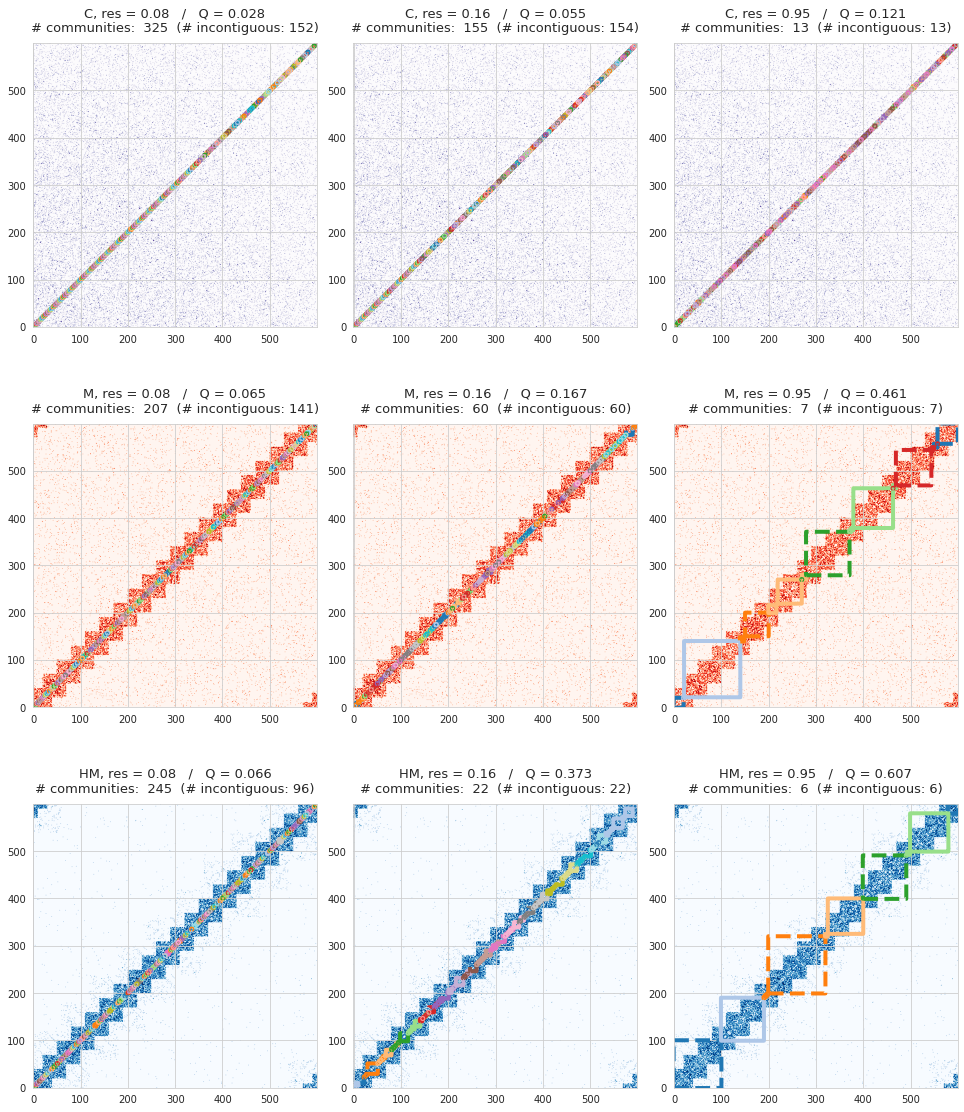

In [40]:
# HIDE CODE


sns.set_style('whitegrid')
idxs_to_display = [300, 400, 659]
fig, axes = plt.subplots(len(graphs), len(idxs_to_display), figsize=(13.5, 16))

for j, name in enumerate(graphs.keys()):
    for i, idx in enumerate(idxs_to_display):
        axes[j, i].imshow(adjacencies[name], cmap=cmaps[name])
        axes[j, i].invert_yaxis()

        community_dict = list(communities_louvain[name].values())[idx]
        community_list = list(community_dict.values())
        palette = sns.color_palette('tab20', n_colors=len(community_list))
        num_incontiguous = 0
        for ll, (comm_list, color) in enumerate(zip(community_list, palette)):
            contiguous_list = []
            for k, g in itertools.groupby(enumerate(comm_list), lambda ix: ix[0]-ix[1]):
                contiguous_list.append(list(map(itemgetter(1), g)))

            if len(contiguous_list) > 1:
                num_incontiguous += 1

            for item in contiguous_list:
                rect = patches.FancyBboxPatch(
                    (item[0],) * 2,
                    item[-1] - item[0],
                    item[-1] - item[0],
                    linewidth=4,
                    edgecolor=color,
                    facecolor='none',
                    boxstyle="round,pad=1",
                    ls='--' if ll%2==0 else '-',
                )
                axes[j, i].add_patch(rect)

        msg = "{:s}, res = {:.2f}   /   Q = {:.3f}\n# communities:  {:d}  (# incontiguous: {:d})"
        msg = msg.format(
            name, list(modularities_louvain[name].keys())[idx],
            list(modularities_louvain[name].values())[idx],
            len(community_list), num_incontiguous,
        )
        axes[j, i].set_title(msg, fontsize=13, y=1.02)

fig.tight_layout()
plt.show()

just like before, interpret this too

In [4]:
eigs = {k: np.linalg.eigh(a) for k, a in adjacencies.items()}

## Spectral decomposition

It is interesting to look at eigenspectrum of adjacency matrix.  It can be insightful about linearized dynamics and so on.

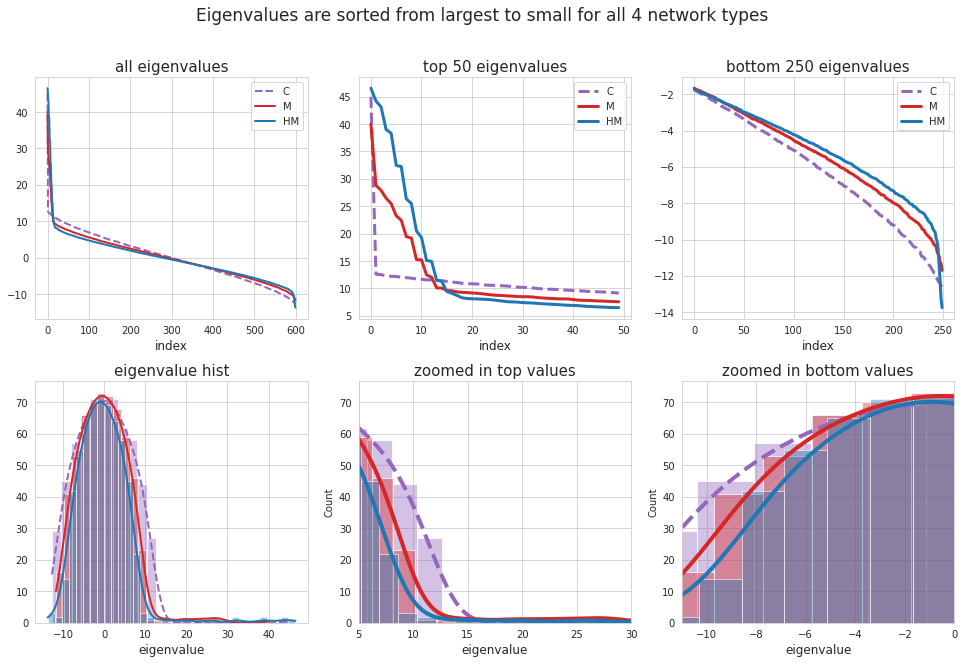

In [5]:
# HIDE CODE


sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 3, figsize=(13.5, 9))

num_top_eig = 50
num_bot_eig = 250
for k, color in colors.items():
    ls = '--' if k in ['C', 'ER'] else '-'
    axes[0, 0].plot(sorted(eigs[k][0], reverse=True), lw=2, color=color, ls=ls, label=k)
    axes[0, 1].plot(sorted(eigs[k][0], reverse=True)[:num_top_eig], lw=3, color=color, ls=ls, label=k)
    axes[0, 2].plot(sorted(eigs[k][0], reverse=True)[-num_bot_eig:], lw=3, color=color, ls=ls, label=k)
    
    sns.histplot(eigs[k][0], color=color, label=k, alpha=0.4, ax=axes[1, 0],
                 kde=True, line_kws={'lw': 2, 'ls': ls})
    sns.histplot(eigs[k][0], color=color, label=k, alpha=0.4, ax=axes[1, 1],
                 kde=True, line_kws={'lw': 4, 'ls': ls})
    sns.histplot(eigs[k][0], color=color, label=k, alpha=0.4, ax=axes[1, 2],
                 kde=True, line_kws={'lw': 4, 'ls': ls})
    
axes[0, 0].set_title('all eigenvalues', fontsize=15)
axes[0, 1].set_title('top {:d} eigenvalues'.format(num_top_eig), fontsize=15)
axes[0, 2].set_title('bottom {:d} eigenvalues'.format(num_bot_eig), fontsize=15)
axes[1, 0].set_title('eigenvalue hist', fontsize=15)
axes[1, 1].set_title('zoomed in top values'.format(num_top_eig), fontsize=15)
axes[1, 2].set_title('zoomed in bottom values'.format(num_bot_eig), fontsize=15)

axes[1, 1].set_xlim(5, 30)
axes[1, 2].set_xlim(-11, 0)
for j in range(3):
    axes[0, j].set_xlabel('index', fontsize=12)
    axes[1, j].set_xlabel('eigenvalue', fontsize=12)
    if j == 0:
        axes[0, 0].set_ylabel('eigenvalue', fontsize=12)
        axes[1, 0].set_ylabel('count', fontsize=12)
    else:
        axes[0, 0].set_ylabel('')
        axes[1, 0].set_ylabel('')
    axes[0, j].legend()

fig.suptitle('Eigenvalues are sorted from largest to small for all 4 network types', fontsize=17, y=1.02)
fig.tight_layout()
    
plt.show()

### Localization analysis

Add the anderson stuff here.

#### Inverse participation ratio (IPR)

Blah blah

interpret graph

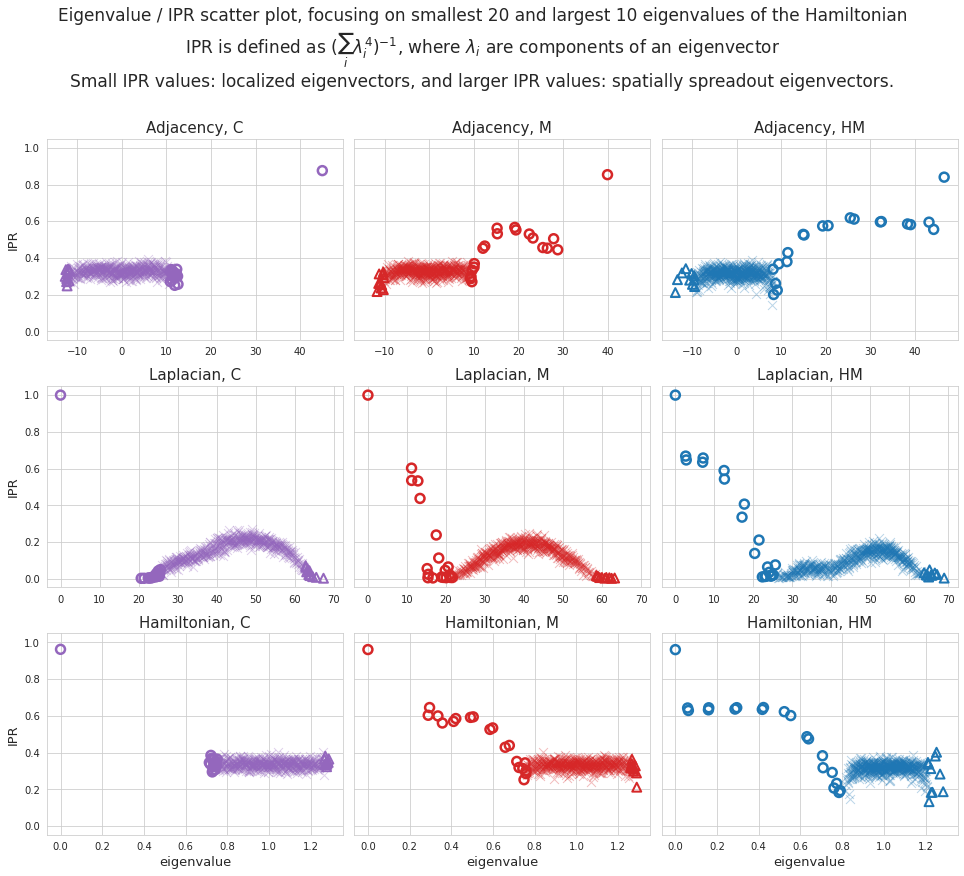

In [59]:
# HIDE CODE


num_top = num_blocks * 2
num_bot = num_blocks
plot_items = {
    'Adjacency': adjacencies,
    'Laplacian': laplacians,
    'Hamiltonian': norm_laplacians,
}

sns.set_style('whitegrid')
nrows, ncols = len(plot_items), len(graphs)
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 12), sharex='row', sharey='all')
if len(axes.shape) < 2:
    axes = axes.reshape(nrows, ncols)

for j, k in enumerate(graphs.keys()):
    for i, (name, mat_dict) in enumerate(plot_items.items()):
        w, v = np.linalg.eigh(mat_dict[k])
        ipr = 1 / np.power(v, 4).sum(0)
        ipr /= len(ipr)

        if name == 'Adjacency':
            sorted_indxs = np.argsort(w)
        else:
            sorted_indxs = np.argsort(w)[::-1]

        axes[i, j].scatter(w[sorted_indxs[num_bot:-num_top]], ipr[sorted_indxs[num_bot:-num_top]],
                           color=colors[k], marker='x', s=80, lw=1., alpha=0.3)
        axes[i, j].scatter(w[sorted_indxs[:num_bot]], ipr[sorted_indxs[:num_bot]],
                           color='none', edgecolors=colors[k], marker='^', s=80, lw=2)
        axes[i, j].scatter(w[sorted_indxs[-num_top:]], ipr[sorted_indxs[-num_top:]],
                           color='none', edgecolors=colors[k], s=80, lw=2.5)
        axes[i, j].set_title('{:s}, {:s}'.format(name, k), fontsize=15)
        if i == nrows - 1:
            axes[i, j].set_xlabel('eigenvalue', fontsize=13)
        if j == 0:
            axes[i, j].set_ylabel('IPR', fontsize=13)

msg = 'Eigenvalue / IPR scatter plot, focusing on smallest {:d} and largest {:d} eigenvalues of the Hamiltonian\n'
msg += 'IPR is defined as $(\sum_i \lambda_i^4)^{{-1}}$, where $\lambda_i$ are components of an eigenvector\n'
msg += 'Small IPR values: localized eigenvectors, and larger IPR values: spatially spreadout eigenvectors.'
fig.suptitle(msg.format(num_top, num_bot), fontsize=17, y=1.01)
fig.tight_layout()
plt.show()

interpret graph

#### Plotting eigenvectors

Here I will plot some of the eigenvectors for different networks to see how they are different.

##### top eigenvectors ordered by eigenvalue size

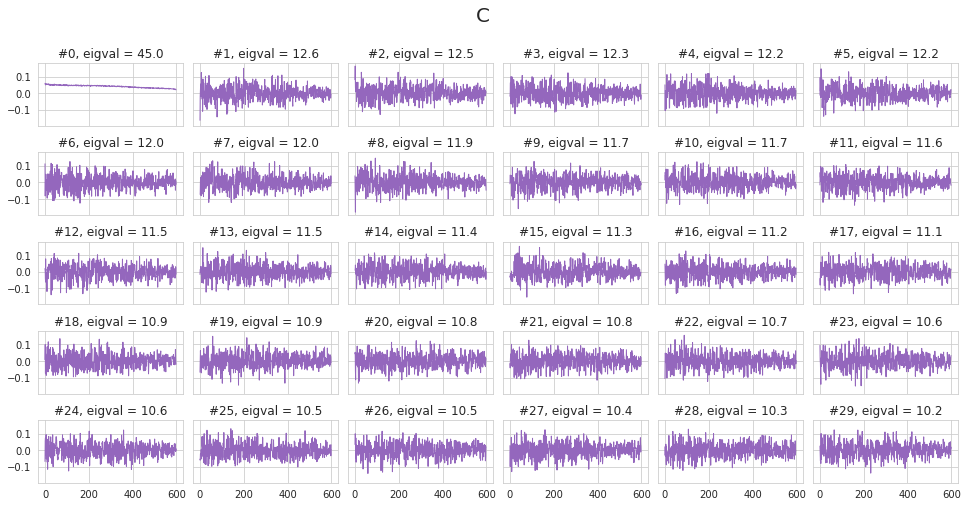

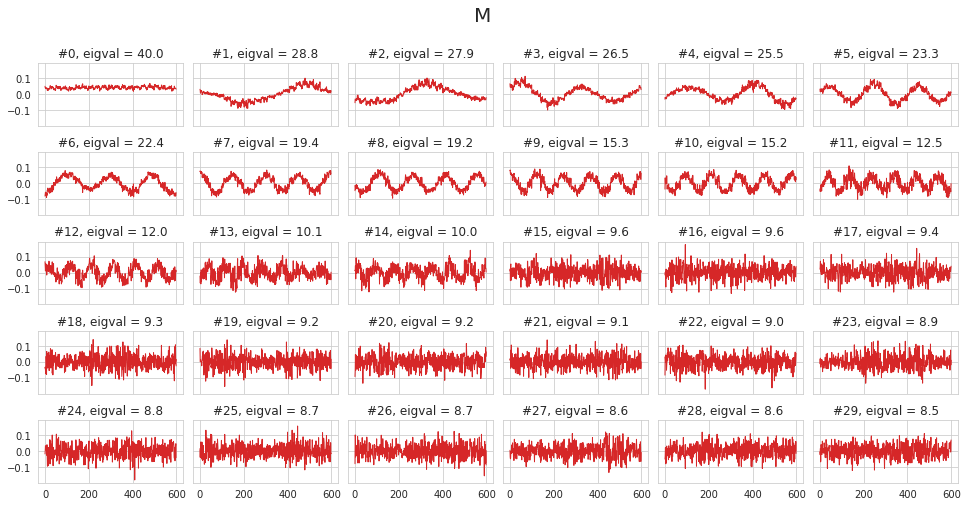

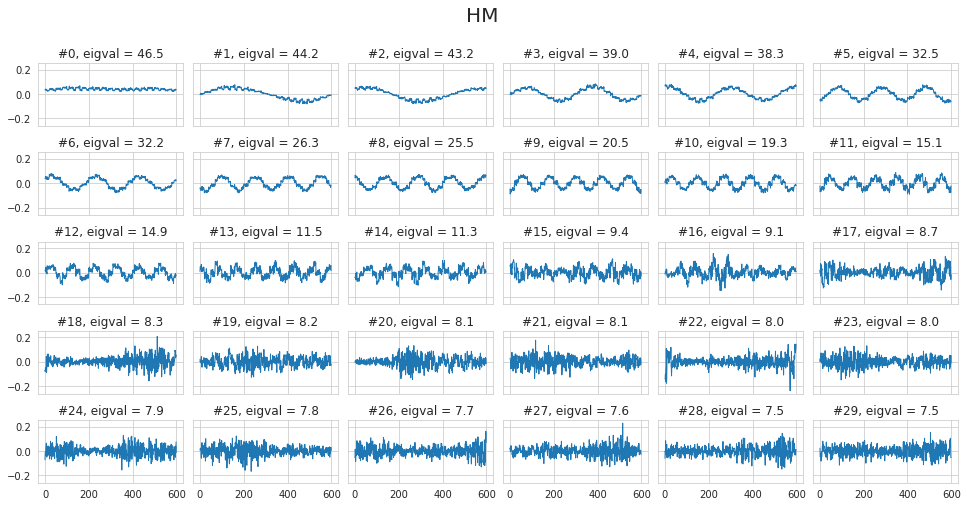

In [45]:
# HIDE CODE


sns.set_style('whitegrid')
nrows, ncols = 5, 6

for k, (w, v) in eigs.items():
    sort_idxs = np.argsort(w)[::-1]

    fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 7), sharex='all', sharey='all')
    for idx in range(nrows*ncols):
        i, j = idx//ncols, idx%ncols 
            # sort_abs_idxs = np.argsort(np.abs(w))
        axes[i, j].plot(v[:, sort_idxs[idx]], color=colors[k], label=k, lw=1)
        axes[i, j].set_title('#{:d}, eigval = {:.1f}'.format(idx, w[sort_idxs[idx]]))

    fig.suptitle(k, fontsize=20, y=1.)
    fig.tight_layout()
    plt.show()

##### Hamiltonian bottom eigs

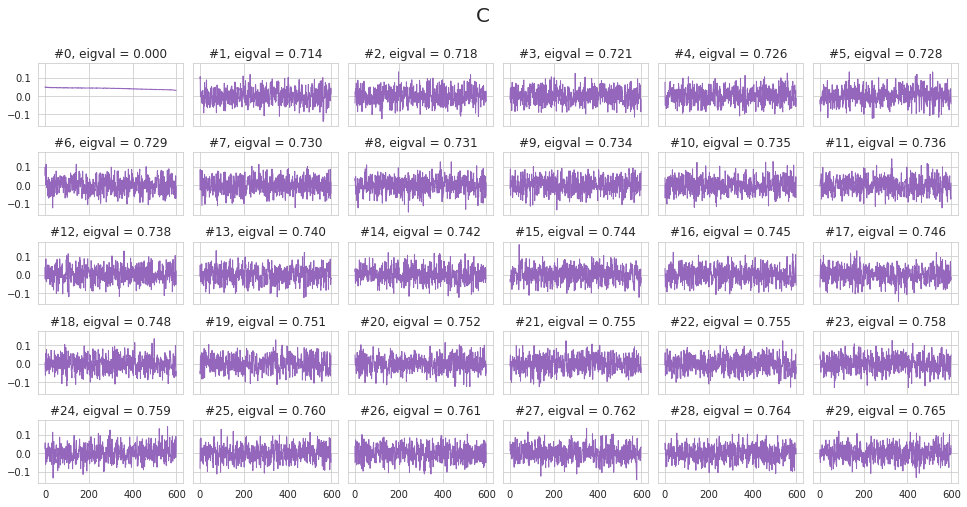

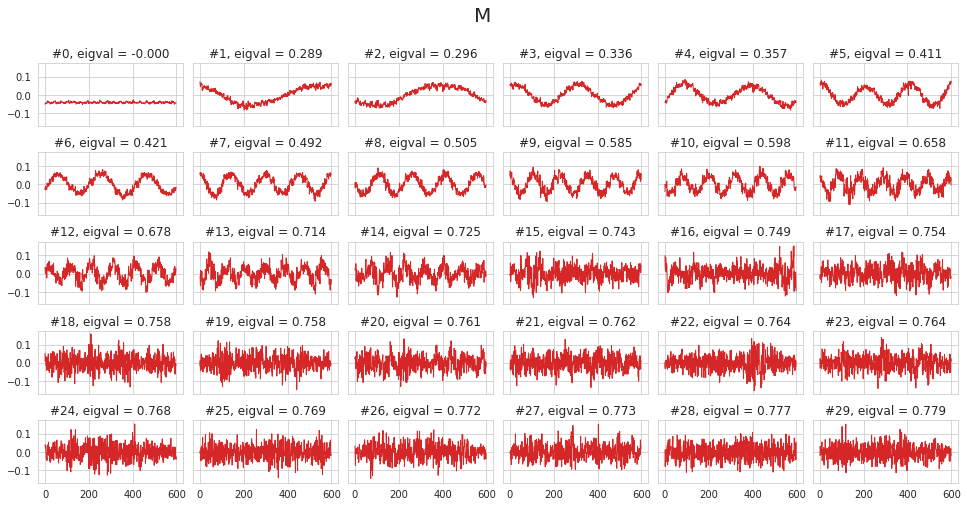

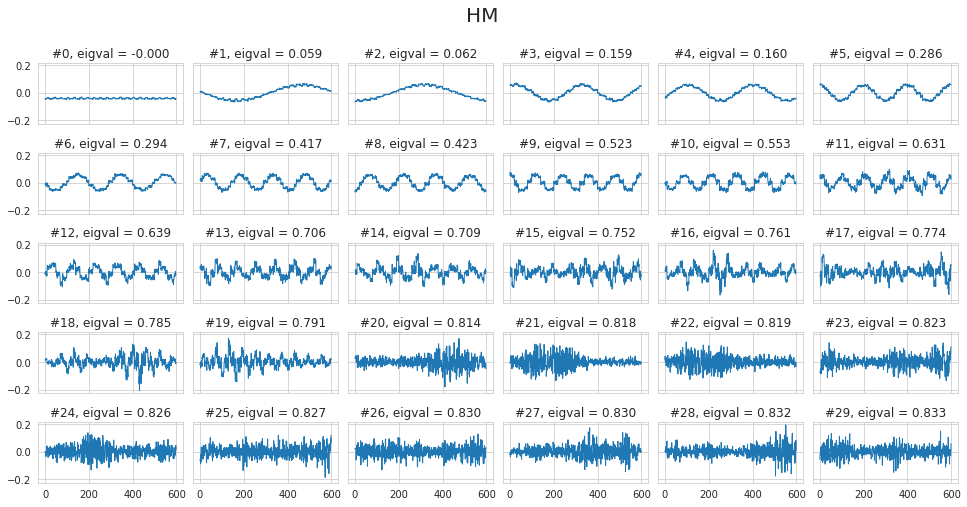

In [48]:
# HIDE CODE


sns.set_style('whitegrid')
nrows, ncols = 5, 6

for k, h in norm_laplacians.items():
    w, v = np.linalg.eigh(h)
    sort_idxs = np.argsort(w)#[::-1]

    fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 7), sharex='all', sharey='all')
    for idx in range(nrows*ncols):
        i, j = idx//ncols, idx%ncols 
            # sort_abs_idxs = np.argsort(np.abs(w))
        axes[i, j].plot(v[:, sort_idxs[idx]], color=colors[k], label=k, lw=1)
        axes[i, j].set_title('#{:d}, eigval = {:.3f}'.format(idx, w[sort_idxs[idx]]))

    fig.suptitle(k, fontsize=20, y=1.)
    fig.tight_layout()
    plt.show()

##### Hamiltonian top eigs

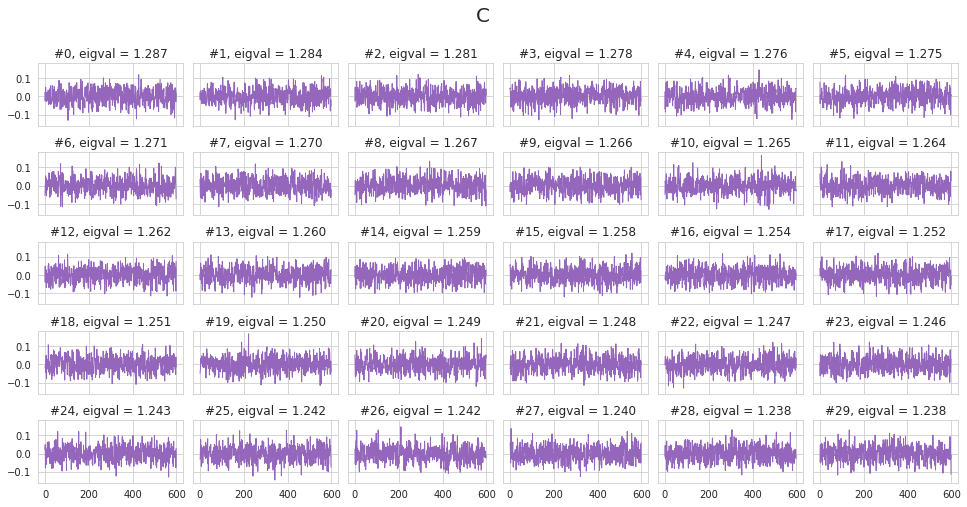

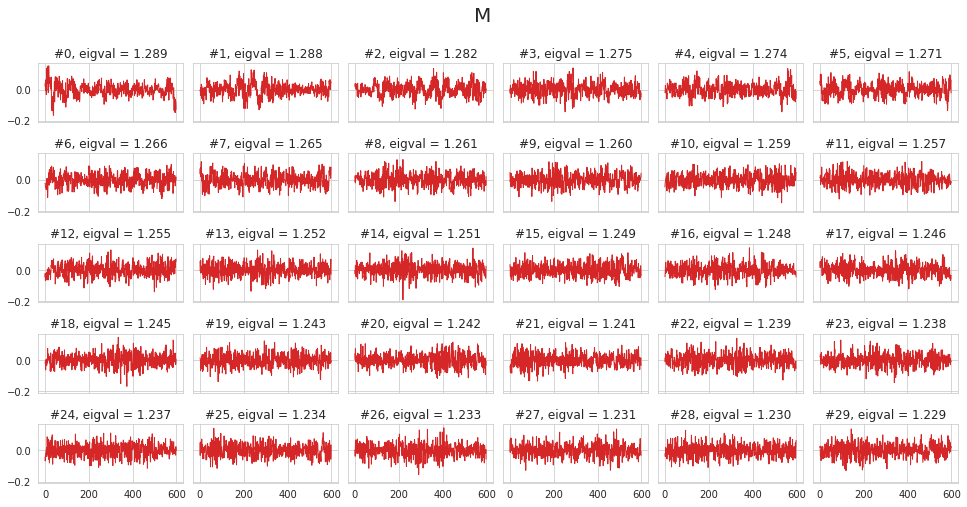

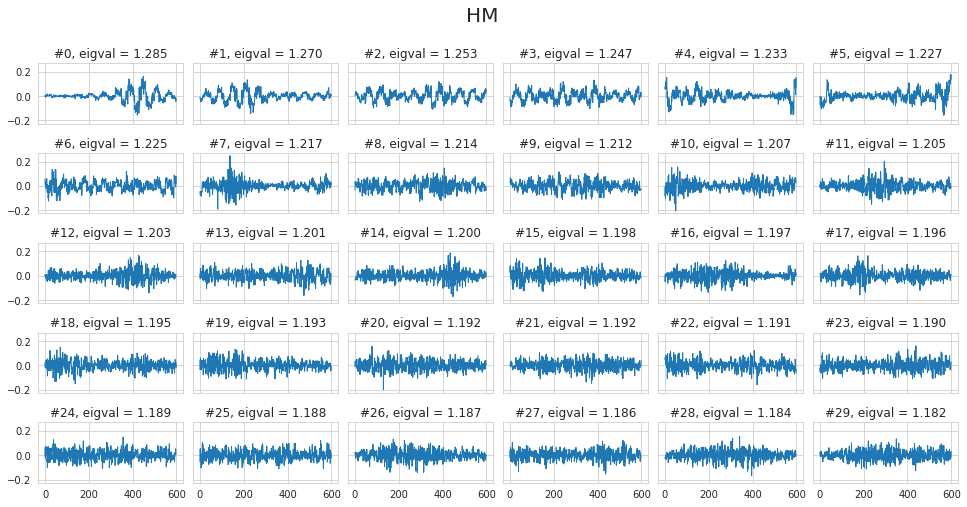

In [49]:
# HIDE CODE


sns.set_style('whitegrid')
nrows, ncols = 5, 6

for k, h in norm_laplacians.items():
    w, v = np.linalg.eigh(h)
    sort_idxs = np.argsort(w)[::-1]

    fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 7), sharex='all', sharey='all')
    for idx in range(nrows*ncols):
        i, j = idx//ncols, idx%ncols 
            # sort_abs_idxs = np.argsort(np.abs(w))
        axes[i, j].plot(v[:, sort_idxs[idx]], color=colors[k], label=k, lw=1)
        axes[i, j].set_title('#{:d}, eigval = {:.3f}'.format(idx, w[sort_idxs[idx]]))

    fig.suptitle(k, fontsize=20, y=1.)
    fig.tight_layout()
    plt.show()

### Overlapping communities

In [66]:
import demon

In [ ]:
# run algorithm
communities_demon = {}

for k, g in tqdm(graphs.items(), leave=False):
    tmp = {}
    for epsilon in tqdm(np.linspace(0, 1, max_k+1), leave=False):
        dm = demon.Demon(g, epsilon=epsilon, min_community_size=3)
        coms = dm.execute()
        tmp[epsilon] = coms

    communities_demon[k] = tmp


# process results
modularities_demon = {}
num_communities_demon = {}

for k, g in graphs.items():
    modul = {}
    num_comm = {}
    for epsilon, community_list in communities_demon[k].items():
        try:
            modul[epsilon] = nx_comm.modularity(g, communities=community_list)
        except:
            modul[epsilon] = 0.
        num_comm[epsilon] = len(community_list)
    
    modularities_demon[k] = modul
    num_communities_demon[k] = num_comm

Exec: 100%|████████████████████████

Time:  'execute' 0.94 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.93 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.93 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.88 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.95 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.99 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.95 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.90 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.96 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.96 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.98 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.98 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.89 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.90 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.99 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.96 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.90 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.93 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.92 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.92 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.98 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.94 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.96 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.96 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.94 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.94 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.99 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.98 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.94 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.06 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.91 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.21 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.07 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.98 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.16 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.10 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.02 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.16 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.17 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.25 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.26 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.36 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.29 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.38 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.48 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.50 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.42 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.46 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.47 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.50 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.51 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.77 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.81 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.80 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.89 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.89 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.94 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.80 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.93 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 2.14 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.89 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 2.19 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 2.25 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 2.40 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 2.30 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 2.31 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 2.30 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 2.42 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 2.50 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 2.44 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 2.92 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 2.72 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 2.76 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 2.77 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 2.79 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 2.80 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 3.15 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 3.27 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 3.14 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 3.09 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 3.86 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 3.78 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 3.50 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 3.47 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 3.63 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 3.79 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 3.85 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 3.76 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 3.75 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 3.78 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 3.92 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 3.78 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 3.74 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 3.76 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 3.75 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 3.64 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 3.57 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 3.97 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 3.70 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 3.80 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 3.73 sec
------------------------------------


Exec: 100%|████████████████████████

Time:  'execute' 0.95 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.00 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.00 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.04 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.00 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.08 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.06 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.00 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.95 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.92 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.91 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.90 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.91 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.91 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.91 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.93 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.94 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.93 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.93 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.94 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.91 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.90 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.91 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.91 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.91 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.91 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.91 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.91 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.91 sec
------------------------------------



Exec:  20%|████▊                   

In [ ]:
# process results
modularities_demon = {}
num_communities_demon = {}

for k, g in graphs.items():
    modul = {}
    num_comm = {}
    for epsilon, partition in communities_demon[k].items():
        community_list = [list(item) for item in partition]
        try:
            modul[epsilon] = nx_comm.modularity(g, communities=community_list)
        except:
            modul[epsilon] = 0.
        num_comm[epsilon] = len(community_list)
    
    modularities_demon[k] = modul
    num_communities_demon[k] = num_comm

In [ ]:
# HIDE CODE


fig, axes = plt.subplots(1, 2, figsize=(13, 4.5), sharex='all')

for k, color in colors.items():
    x0, y0 = tuple(zip(*modularities_demon[k].items()))
    axes[0].plot(x0, y0, lw=3, color=color)
    ls = '--' if k in ['M', 'HM'] else ':'
    max_mod_idx = np.argmax(y0)
    max_mod = y0[max_mod_idx]
    res_at_max_mod = x0[max_mod_idx]
    lbl = '{}, max Q = {:.3f}'.format(k, max_mod)
    axes[0].axvline(res_at_max_mod, color=color, lw=2, ls=ls, label=lbl)
    
    x1, y1 = tuple(zip(*num_communities_demon[k].items()))
    axes[1].loglog(x1, y1, lw=3, color=color)
    lbl = '{}, # comm = {:d}'.format(k, y1[max_mod_idx])
    axes[1].axvline(res_at_max_mod, color=color, lw=2, ls=ls, label=lbl)

axes[0].set_title('Q as a function of epsilon', fontsize=15, y=1.02)
axes[0].set_xlabel('epsilon (log)', fontsize=12)
axes[0].set_ylabel('Q modularity', fontsize=12)
axes[0].legend(loc='upper left')

axes[1].set_title('Num communities as a function of epsilon', fontsize=15, y=1.02)
axes[1].set_xlabel('epsilon (log)', fontsize=12)
axes[1].set_ylabel('# communities (log)', fontsize=12)
axes[1].legend(loc='upper right')

fig.tight_layout()
plt.show()

In [ ]:
# HIDE CODE


sns.set_style('whitegrid')
idxs_to_display = [10, 20, 50]
fig, axes = plt.subplots(len(graphs), len(idxs_to_display), figsize=(13.5, 15))

for j, name in enumerate(graphs.keys()):
    for i, idx in enumerate(idxs_to_display):
        axes[j, i].imshow(adjacencies[name], cmap=cmaps[name])
        axes[j, i].invert_yaxis()

        community_list = list(communities_demon[name].values())[idx]
        palette = sns.color_palette('tab20', n_colors=len(community_list))
        num_incontiguous = 0
        for ll, (comm_list, color) in enumerate(zip(community_list, palette)):
            contiguous_list = []
            for k, g in itertools.groupby(enumerate(comm_list), lambda ix: ix[0]-ix[1]):
                contiguous_list.append(list(map(itemgetter(1), g)))

            if len(contiguous_list) > 1:
                num_incontiguous += 1

            for item in contiguous_list:
                rect = patches.FancyBboxPatch(
                    (item[0],) * 2,
                    item[-1] - item[0],
                    item[-1] - item[0],
                    linewidth=2,
                    edgecolor=color,
                    facecolor='none',
                    boxstyle="round,pad=1",
                    ls='--' if ll%2==0 else '-',
                )
                axes[j, i].add_patch(rect)

        msg = "{:s}, res = {:.2f}   /   Q = {:.3f}\n# communities:  {:d}  (# incontiguous: {:d})"
        msg = msg.format(
            name, list(modularities_demon[name].keys())[idx],
            list(modularities_demon[name].values())[idx],
            len(community_list), num_incontiguous,
        )
        axes[j, i].set_title(msg, fontsize=13, y=1.02)

fig.tight_layout()
plt.show()

## Discussion

TODO